In [2]:
import numpy as np
import pandas as pd
import json
import codecs
import datetime
import os
import sys

In [3]:
sys.path.append('.')

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt


In [8]:
path = '/Users/smuel/AndroidStudioProjects/LuckyMeIntgratedSDK/metadata_init_phase/'

In [7]:
from vector_creator.raw_to_df.rawdata_to_df import *
from vector_creator.score_vectors.score_vectors_assembly import *
from vector_creator.preprocess.entropy import *
from vector_creator.preprocess.est_by_df_column import *
from vector_creator.preprocess.auto_regression import *
from vector_creator.stats_models.estimators import *
from vector_creator.score_vectors.vector_indexer import vector_desc_call_logs

In [6]:
y = score_vector_constructor(path, 'photo-gallery')

05fa68e5-0ba3-4783-9c07-42740c4914c6
photo-gallery:  724
-> to small to process
12fa7561-2e77-4334-b9e1-6858ed27570f
photo-gallery:  1448
-> processed
1362474c-0fb5-4932-a33d-5a30f23ac7e3
photo-gallery:  1558
-> processed
148b0326-09e2-404f-9de6-aff6d44f2a38
photo-gallery:  420
-> to small to process
17ac0e20-b292-492c-9adc-faf60a068926
photo-gallery:  1278
-> processed
199ea69c-5e20-4b53-9bfb-0534aaeb68d6
photo-gallery:  311
-> to small to process
1abd59a3-553f-43db-a329-90c28c72afdd
photo-gallery:  462
-> to small to process
20380cd2-055e-4f3a-a339-90a1c7df4e1a
photo-gallery:  3294
-> processed
236b91d2-cefb-405a-9de5-a3673ef1c736
photo-gallery:  1436
-> processed
25174909-3427-42d2-9e14-65f7c95f240b
photo-gallery:  1369
-> processed
25ba2284-51e3-4eb9-a2c8-fa3a0eaeeca9
photo-gallery:  2398
-> processed
29a43c47-05d7-4bb9-909b-e3cae08097ad
photo-gallery:  54
-> to small to process
2afbf7b0-6202-49bb-814f-ddba906bab48
photo-gallery:  607
-> to small to process
2afc4c23-161f-4fc5-b4ba-

In [9]:
y.head(5)

description,mean daily number photos,std daily number photos,huber mean daily number photos,huber std daily number photos,ratio_of_nonzero_values_for_daily_photos,mean number of photos in burst,mean number of bursts a week,mean nightly number photos,std nightly number photos,ratio_of_nonzero_values_for_nightly_photos,mean weekend number photos,std weekend number photos,ratio_of_nonzero_values_for_weekend_photos,ar daily num of photos lag-1,ar daily num of photos lag-2,ar daily num of photos lag-4,entropy on photo category,entropy on daily photos
12fa7561-2e77-4334-b9e1-6858ed27570f,27.320755,150.369579,4.933056,5.248961,0.072011,5.862348,2.330189,5.225000,6.691366,0.062112,69.166667,252.639895,0.025388,23.213346,23.851922,25.280040,0.035811,1.900352
1362474c-0fb5-4932-a33d-5a30f23ac7e3,9.442424,20.723095,4.707420,4.232136,0.069153,2.364188,1.926901,8.955357,22.951186,0.046940,12.640000,27.891762,0.035486,7.578176,7.270128,7.594923,0.195228,5.911040
17ac0e20-b292-492c-9adc-faf60a068926,17.270270,80.860624,5.924570,5.678164,0.055348,6.553846,1.015625,27.076923,110.151268,0.029170,34.285714,129.246127,0.020942,6.374083,6.327040,5.398185,0.030548,3.365487
20380cd2-055e-4f3a-a339-90a1c7df4e1a,10.943522,18.948964,7.647709,6.900941,0.631027,1.849523,25.811594,7.331818,14.828532,0.472103,12.625000,23.839415,0.153191,16.464636,16.032337,17.570474,0.790109,7.213645
236b91d2-cefb-405a-9de5-a3673ef1c736,13.054545,33.344438,5.217365,4.893011,0.604396,2.930612,18.148148,12.606383,35.451561,0.516484,7.593750,11.280125,0.180791,9.221194,9.111159,9.024470,0.256801,4.955326


In [7]:
nrm = normalize_scores(y, 'z-score')

In [10]:
nrm.head(5)

description,mean daily number photos,std daily number photos,huber mean daily number photos,huber std daily number photos,ratio_of_nonzero_values_for_daily_photos,mean number of photos in burst,mean number of bursts a week,mean nightly number photos,std nightly number photos,ratio_of_nonzero_values_for_nightly_photos,mean weekend number photos,std weekend number photos,ratio_of_nonzero_values_for_weekend_photos,ar daily num of photos lag-1,ar daily num of photos lag-2,ar daily num of photos lag-4,entropy on photo category,entropy on daily photos
12fa7561-2e77-4334-b9e1-6858ed27570f,27.320755,150.369579,4.933056,5.248961,0.072011,5.862348,2.330189,5.225000,6.691366,0.062112,69.166667,252.639895,0.025388,23.213346,23.851922,25.280040,0.035811,1.900352
1362474c-0fb5-4932-a33d-5a30f23ac7e3,9.442424,20.723095,4.707420,4.232136,0.069153,2.364188,1.926901,8.955357,22.951186,0.046940,12.640000,27.891762,0.035486,7.578176,7.270128,7.594923,0.195228,5.911040
17ac0e20-b292-492c-9adc-faf60a068926,17.270270,80.860624,5.924570,5.678164,0.055348,6.553846,1.015625,27.076923,110.151268,0.029170,34.285714,129.246127,0.020942,6.374083,6.327040,5.398185,0.030548,3.365487
20380cd2-055e-4f3a-a339-90a1c7df4e1a,10.943522,18.948964,7.647709,6.900941,0.631027,1.849523,25.811594,7.331818,14.828532,0.472103,12.625000,23.839415,0.153191,16.464636,16.032337,17.570474,0.790109,7.213645
236b91d2-cefb-405a-9de5-a3673ef1c736,13.054545,33.344438,5.217365,4.893011,0.604396,2.930612,18.148148,12.606383,35.451561,0.516484,7.593750,11.280125,0.180791,9.221194,9.111159,9.024470,0.256801,4.955326


In [11]:
nrm.to_csv('/Users/smuel/Developer/Python/louie7_mvp/score_vec_photogallery_new.csv')

In [9]:
rdata = list_of_json_files(path)

In [10]:
rdata[0][0]

'05fa68e5-0ba3-4783-9c07-42740c4914c6'

In [11]:
raw = group_metadata(path)

In [12]:
raw

{'unique_ids': ['148b0326-09e2-404f-9de6-aff6d44f2a38',
  '236b91d2-cefb-405a-9de5-a3673ef1c736',
  '25174909-3427-42d2-9e14-65f7c95f240b',
  '2afc4c23-161f-4fc5-b4ba-e567f5327d22',
  '1abd59a3-553f-43db-a329-90c28c72afdd',
  '20380cd2-055e-4f3a-a339-90a1c7df4e1a',
  '17ac0e20-b292-492c-9adc-faf60a068926',
  '25ba2284-51e3-4eb9-a2c8-fa3a0eaeeca9',
  '6ff9fca8-f981-46e5-93cc-4fab4190d758',
  'a296ae00-fcd4-418c-aaae-49b1f13fcbd5',
  '05fa68e5-0ba3-4783-9c07-42740c4914c6',
  '2afbf7b0-6202-49bb-814f-ddba906bab48',
  '588aeafe-5c4d-4bc9-84c5-8ae28029c733',
  '759240f7-1248-4334-aad5-fd384b524d3d',
  '29a43c47-05d7-4bb9-909b-e3cae08097ad',
  '3e4c39d0-d2ec-45c3-91cc-4c80ccf171be',
  '1362474c-0fb5-4932-a33d-5a30f23ac7e3',
  '36f05b2e-4164-49a6-ba0c-d78997ecdcae',
  '5e0b1bf2-2aba-4745-b91f-916554d51e9f',
  '199ea69c-5e20-4b53-9bfb-0534aaeb68d6',
  '12fa7561-2e77-4334-b9e1-6858ed27570f'],
 'file_list': ['05fa68e5-0ba3-4783-9c07-42740c4914c6_11-06-2021_09-53-01.json',
  '12fa7561-2e77-4334-b

In [31]:
uid  = '05fa68e5-0ba3-4783-9c07-42740c4914c6'
file = '05fa68e5-0ba3-4783-9c07-42740c4914c6_11-06-2021_09-53-01.json'
raw_data = json.load(codecs.open(path + file, 'r', 'utf-8-sig'))

In [32]:
raw_data.keys()

dict_keys(['SamplingConfigurations', 'CallLogs', 'ImgMetaData', 'InstallApps', 'LocationInfo', 'BatteryInfo', 'WifiInfo', 'ScreenInfo'])

In [33]:
loc, df_r = create_df_from_init_metadata(uid, raw_data)

In [34]:
df_r.keys()

dict_keys(['05fa68e5-0ba3-4783-9c07-42740c4914c6_SamplingConfigurations', '05fa68e5-0ba3-4783-9c07-42740c4914c6_CallLogs', '05fa68e5-0ba3-4783-9c07-42740c4914c6_ImgMetaData', '05fa68e5-0ba3-4783-9c07-42740c4914c6_InstallApps', '05fa68e5-0ba3-4783-9c07-42740c4914c6_LocationInfo', '05fa68e5-0ba3-4783-9c07-42740c4914c6_BatteryInfo', '05fa68e5-0ba3-4783-9c07-42740c4914c6_WifiInfo', '05fa68e5-0ba3-4783-9c07-42740c4914c6_ScreenInfo'])

In [37]:
clogs = df_r['05fa68e5-0ba3-4783-9c07-42740c4914c6_InstallApps']
len(clogs)

41

In [38]:
clogs.tail(5)

,INSTALL_DATETIME,APP_CATEGORY,APP_VARIANT
36,2020-03-17 11:45:18.157999872,Simulation,Paid Feature
37,2019-11-23 17:17:10.605999872,Sports,Paid Feature
38,2020-10-20 05:22:40.272999936,Photography,Paid Feature
39,2020-03-26 13:05:53.877000192,app not found at app store,Free
40,2020-05-07 17:42:07.743000064,Education,Paid Feature


In [39]:
sample_field = 'INSTALL_DATETIME'
data_field = 'APP_CATEGORY'

In [135]:
cats = clogs.groupby(data_field).agg({data_field: ['count']})
cats.columns = cats.columns.get_level_values(0)

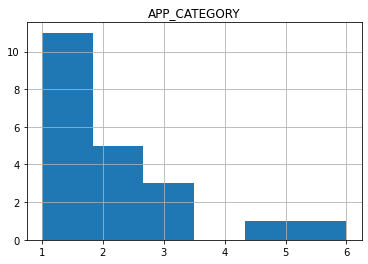

In [136]:
h = cats.hist(column=data_field, bins=6)

In [89]:
cats['APP_CATEGORY'] = cats.values / np.sum(cats.values)

In [44]:
apps = ['Art & Design', 'Auto & Vehicles', 'Beauty', 'Books & Reference', 'Business', 'Comics', 'Communications',
        'Dating', 'Education', 'Entertainment', 'Events', 'Finance', 'Food & Drink', 'Health & Fitness', 'House & Home',
        'Lifestyle', 'Maps & Navigation', 'Medical', 'Music & Audio', 'News & Magazines', 'Parenting',
        'Personalization', 'Photography', 'Productivity', 'Shopping', 'Social', 'Sports', 'Tools', 'Travel & Local',
        'Video Players & Editors', 'Weather', 'Libraries & Demo', 'Action', 'Adventure', 'Arcade', 'Board', 'Cards',
        'Casino', 'Casual', 'Educational', 'Music Games', 'Puzzle', 'Racing', 'Role Playing',
        'Simulation', 'Sport Games', 'Strategy', 'Trivia', 'Word Games', 'Family All Ages', 'Family Action',
        'Family Brain Games', 'Family Create', 'Family Education', 'Family Music & Video', 'Family Pretend Play']

In [137]:
len(cats)/len(apps)

0.375

In [138]:
np.sum(cats.values)

41

In [139]:
cats.index.names = ['category']

In [140]:
cats

,APP_CATEGORY
category,
Action,5
Adventure,3
Arcade,1
Board,1
Books & Reference,1
Business,1
Education,2
Educational,1
Entertainment,2


In [149]:
np.mean(cats.values)

1.9523809523809523

<AxesSubplot:xlabel='category'>

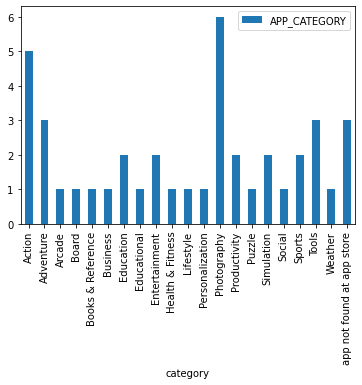

In [141]:
cats.plot(kind='bar')

<AxesSubplot:ylabel='Density'>

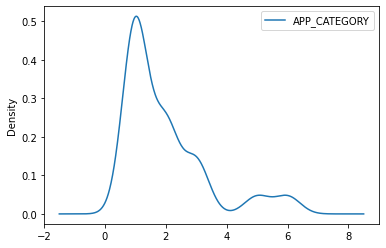

In [155]:
cats.plot.kde(bw_method=0.3)

array([[-1.50000000e+00,  9.02802192e-09],
       [-1.48998999e+00,  1.04104959e-08],
       [-1.47997998e+00,  1.19978098e-08],
       ...,
       [ 8.47997998e+00,  1.09071001e-09],
       [ 8.48998999e+00,  9.46408742e-10],
       [ 8.50000000e+00,  8.20729282e-10]])

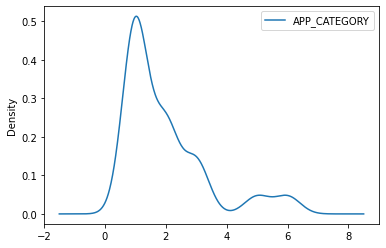

In [143]:
cats.plot.kde(bw_method=0.3).get_lines()[0].get_xydata()

In [144]:
from scipy.stats import gaussian_kde

In [145]:
density = gaussian_kde(cats['APP_CATEGORY'], bw_method=0.3)

In [147]:
x = np.linspace(-10,10,200)
y = density(x)

In [56]:
h.all()

<AxesSubplot:title={'center':"('APP_CATEGORY', 'count')"}>

In [28]:
daily_func(clogs, sample_field, data_field, 'count', 'D')

[4.184971098265896,
 6.403612115091916,
 2.707334951659146,
 1.9737065162609069,
 0.2972508591065292]

In [53]:
x = clogs.groupby(pd.Grouper(key=sample_field, freq='1Min')).agg({data_field: ['count']})

In [1]:
x

NameError: name 'x' is not defined

In [126]:
x0 = x.loc[(x!=0).any(axis=1)]

In [127]:
type(x0)

pandas.core.frame.DataFrame

In [129]:
x0.reset_index(level=0, inplace=True)

In [131]:
x0.columns

MultiIndex([('IMAGE_DATE_TIME',      ''),
            (     'IMAGE_TYPE', 'count')],
           )

In [134]:
x0.columns = x0.columns.get_level_values(0)

In [141]:
np.mean(x0.IMAGE_TYPE.values)

1.8805194805194805

In [136]:
z = x0.groupby(pd.Grouper(key=sample_field, freq='W')).agg({data_field: ['count']})

In [139]:
z.head(5)

,IMAGE_TYPE
,count
IMAGE_DATE_TIME,
2019-10-20,3
2019-10-27,2
2019-11-03,11
2019-11-10,1
2019-11-17,3


In [145]:
np.mean(z.values.T[0])

4.583333333333333

In [20]:
daily_cont_event(clogs, sample_field, data_field)

[4.03757225433526, 6.0235596126069035, 2.649869057922282, 1.9221669965919856]

In [21]:
nh = NightHours(sample_field)
nh(clogs, data_field)

[4.549019607843137, 2.3428946330763263]

In [22]:
loc_tuple = (loc[0]['Latitude'], loc[0]['Longitude'])
wh = WeekendHours(clogs, sample_field, loc_tuple)
wh(data_field, 'D')

[ 1  3 13  7  4  9 10  1  8  1 36  1  5 11  1  4  3  2  2  1  7  4  1  3
  8  2 17  1  1  4 31  2  2  3  1  1  1 42  1  3  2  4  3  1  3  1]


[5.913043478260869, 8.853459375360183, 3.7868184083633945, 3.408258328067422]

In [23]:
entropy_of_cat(clogs, data_field, photo_gallery['categories'], 'photo-gallery')

[0.2297391051374809]

In [24]:
entropy_of_amount(clogs, sample_field, data_field)

[6.535033406107279]

In [25]:
train, test = ar_count(clogs, sample_field, data_field)

In [26]:
len(test)

4

In [27]:
ar(train, test, 2, True)

[7.460553966872168]